# Figure 1: Cosine contours

In [1]:
import numpy as np
import scipy 
from scipy.fftpack import dct, idct

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from music21 import converter
matplotlib.style.use('styles.mplstyle')

import sys
sys.path.append('../src')
from phrases import extract_phrases_from_file
from melodic_contour import stream_to_contour, Contour
sys.path.append('../')
from helpers import cm2inch, title

In [2]:
phrases = extract_phrases_from_file('../figures/fig01/nova005.krn')

../src/phrases.py:75: Music21DeprecationWarning: parseFile was deprecated and will disappear soon. Find alternative methods.
  song = humdrum.parseFile(filename)


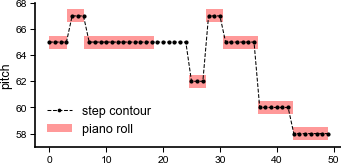

In [3]:
def show_phrase(phrase, show_legend=True, note_color='r'):
    # Extract note durations etc
    notes = phrase.flat.notes
    offsets = [float(n.offset) for n in notes]
    pitches = [n.pitch.ps for n in notes]
    durations = [n.quarterLength for n in notes]
    
    # Deal with phrases starting with a rest
    if offsets[0] > 0:
        duration = duration - offsets[0]
        offsets = [x - offsets[0] for x in offsets]
    
    # Ensure the final note has the proper duration
    offsets.append(phrase.quarterLength)
    pitches.append(pitches[-1])

    # Plot Piano roll
    total_duration = phrase.quarterLength / 49
    for offset, duration, pitch in zip(offsets, durations, pitches):
        height = 1
        bottom_left = (offset/total_duration, pitch - height/2)
        rect = patches.Rectangle(bottom_left, duration/total_duration - 0.01, height,
                                 facecolor=note_color, alpha=.4, label='piano roll')
        plt.gca().add_patch(rect)
    
    # Plot interpolated contour
    func = scipy.interpolate.interp1d(offsets, pitches, kind='previous')
    xs = np.linspace(0, offsets[-1], 50)
    ys = func(xs)
    plt.plot(ys, 'k.--', lw=.5, ms=2, label='step contour')
    plt.ylabel('pitch')

    if show_legend:
        # Legend: don't repeat labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        
fig = plt.figure(figsize=cm2inch(6, 3), constrained_layout=True)
show_phrase(phrases[4])

### DCT

In [4]:
def alpha(k, N):
    if k == 0:
        return 1 / np.sqrt(N)
    else:
        return np.sqrt(2/N)
    
def cosine(n, k, N):
    return alpha(k, N) * np.cos(np.pi * (2*n + 1) * k / (2*N))

def dct_matrix(N):
    """Discrete Cosine Transform NxN matrix where every column is a
    discrete cosine function. Columns are normalized, so the output
    is an orthogonal matrix."""
    ns = np.arange(N)
    return np.array([cosine(ns, k, N) for k in ns]).T

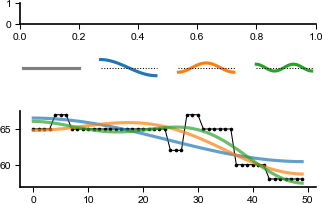

In [5]:
def show_dct(ys, gs, loc=(0,0), N=50):
    fig = plt.gcf()
    xs = np.arange(N)
    for k in range(4):
        ax = fig.add_subplot(gs[loc[0]+0, loc[1]+k])
        u = dct(ys, norm='ortho')[k] * cosine(xs, k, N)
        color = '0.5' if k == 0 else f'C{k-1}'
        plt.plot(xs, u, c=color)
        plt.axis('off')
        if k > 0:
            plt.plot([0, 50], [0, 0], 'k:', lw=.5, )
            plt.ylim(-4, 4)

    ax = fig.add_subplot(gs[loc[0]+1:loc[0]+3, loc[1]:loc[1]+4])
    plt.plot(xs, ys, 'k.-', lw=.5, ms=1.5)

    cs = dct(ys, norm='ortho')
    plt.plot(idct(cs[:2], n=50, norm='ortho'), alpha=.7, lw=1.5)
    plt.plot(idct(cs[:3], n=50, norm='ortho'), alpha=.7, lw=1.5)
    plt.plot(idct(cs[:4], n=50, norm='ortho'), alpha=.7, lw=1.5)

contour = stream_to_contour(phrases[4])
times, pitches = contour.times, contour.pitches
func = scipy.interpolate.interp1d(times/times[-1], pitches, kind='previous')
xs = np.linspace(0, 1, 50)
ys = func(xs)
    
fig = plt.figure(figsize=cm2inch(6,4), tight_layout=True)
gs = gridspec.GridSpec(4, 4)
fig.add_subplot(gs[0, :])
show_dct(ys, gs, loc=(1, 0))

/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


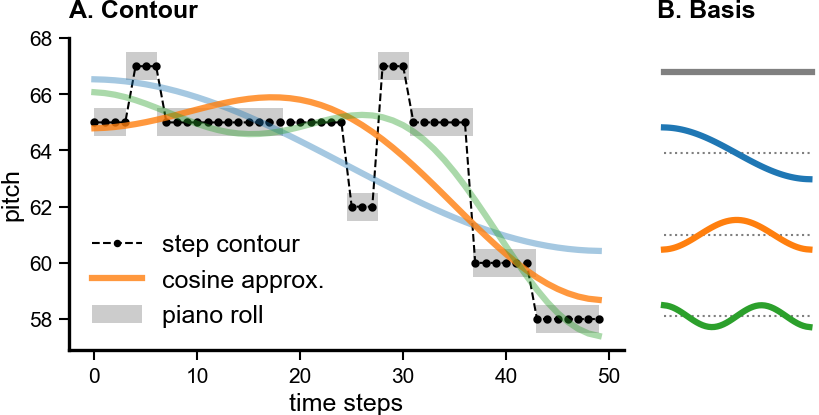

In [6]:
def show_melody(stream, gs, loc=(0,0), N=50):
    contour = stream_to_contour(phrases[4])
    times, pitches = contour.times, contour.pitches
    func = scipy.interpolate.interp1d(times/times[-1], pitches, kind='previous')
    xs = np.linspace(0, 1, 50)
    ys = func(xs)
    
    ax = fig.add_subplot(gs[loc[0]:loc[0]+4, loc[1]:loc[1]+3])
    show_phrase(stream, note_color='.5', show_legend=False)
    plt.xlabel('time steps')
    title('A. Contour')
    
    cs = dct(ys, norm='ortho')
    plt.plot(idct(cs[:2], n=50, norm='ortho'), alpha=.4, lw=1.5)
    plt.plot(idct(cs[:3], n=50, norm='ortho'), alpha=.8, lw=1.5, label='cosine approx.')
    plt.plot(idct(cs[:4], n=50, norm='ortho'), alpha=.4, lw=1.5)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    xs = np.arange(N)
    for k in range(4):
        ax = fig.add_subplot(gs[loc[0]+k, loc[1]+3])
        if k > 0:
            plt.plot([0, 50], [0, 0], 'k:', lw=.5, alpha=.5)
            plt.ylim(-4, 4)
        else:
            title('B. Basis')

        u = dct(ys, norm='ortho')[k] * cosine(xs, k, N)
        color = '0.5' if k == 0 else f'C{k-1}'
        plt.plot(xs, u, '-', c=color, lw=1.5)
        plt.axis('off')
                
fig = plt.figure(figsize=cm2inch(8.2, 3.5), constrained_layout=True)
gs = gridspec.GridSpec(4, 4)
show_melody(phrases[4], gs)

### Cosine space

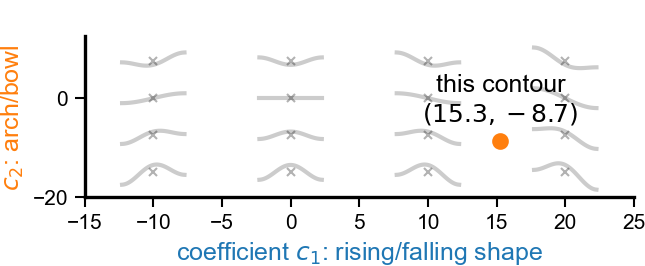

In [7]:
N = 50
ns = np.arange(N)
u1 = cosine(ns, 1, N) 
u2 = cosine(ns, 2, N)
u3 = cosine(ns, 3, N)

def show_point(x, y, z=0, w=5, h=25, pad=1):
    ax = plt.gca()
    axins = ax.inset_axes([x - w/2, y-h/2, w, h], transform=ax.transData)
    axins.plot(x * u1 + y * u2 + z*u3, lw=1, c='k', alpha=.2)
    plt.plot(x, y, 'x', c='k', ms=2, markeredgewidth=0.5, alpha=.3)
    axins.set_ylim(-25, 25)
    axins.axis('off')

def show_cosine_grid(x_grid, y_grid, pad=5):
    plt.xlim(min(x_grid)-pad, max(x_grid)+pad)
    plt.ylim(min(y_grid)-pad, max(y_grid)+pad)
    for x in x_grid:
        for y in y_grid:
            show_point(x, y)

def show_cosine_space(ys):
    show_cosine_grid([-10, 0, 10, 20], [-15, -7.5, 0, 7.5])
    
    cs = dct(ys, norm='ortho')
    plt.plot(cs[1], cs[2], 'o', color='C1')
    plt.annotate(f'this contour\n$({cs[1]:.1f}, {cs[2]:.1f})$', 
                 xy=(cs[1], cs[2]),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center',
                 fontsize=6)
    plt.xlabel('coefficient $c_1$: rising/falling shape', color='C0')
    plt.ylabel('$c_2$: arch/bowl', color='C1')

plt.figure(figsize=cm2inch(6, 3), tight_layout=True)
show_cosine_space(ys)

## Combine all figures

/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # Remove the CWD from sys.path while we load stuff.
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # This is added back by InteractiveShellApp.init_path()
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  # This is added back by InteractiveShellApp.init_path()
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small

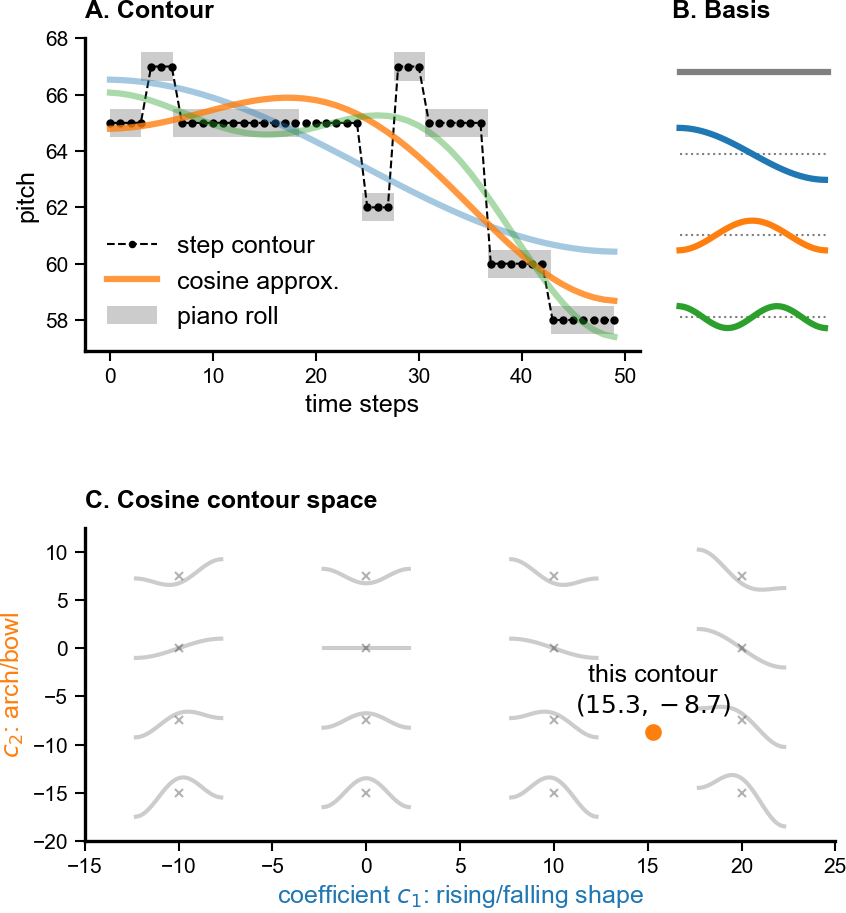

In [8]:
fig = plt.figure(figsize=cm2inch(8.2, 9), tight_layout=True)
gs = gridspec.GridSpec(10, 4)
show_melody(phrases[4], gs)

fig.add_subplot(gs[6:, :])
show_cosine_space(ys)
plt.title('C. Cosine contour space', 
          y=1, fontweight='bold', x=0, ha='left')

plt.tight_layout()
plt.savefig('../figures/fig01/fig01-raw.pdf')